# Model inference workflow demo notebook

In [1]:
import torch
import numpy as np

import sys
sys.path.append("../..")
from src.models.utils import model_setup, metrics
from src.models.utils.configuration import AttrDict

## Define a Configuration dictionary for this experiment

In [2]:
# Define some options
model_name = 'linear' # options: 'unet', 'linear', 'simplecnn'
channel_configuration_name = 'all'

opt = {
    'model': model_name,
    'device': 'cpu',
    'model_folder': f'../../src/models/checkpoints/{model_name}/', # TODO different channel configuration means different model
    'max_tile_size': 128,
    'num_class': 3,
    'channel_configuration' : channel_configuration_name,
    'num_channels': len(model_setup.CHANNELS_CONFIGURATIONS[channel_configuration_name]),
}
opt = AttrDict.from_nested_dicts(opt)

## Load inference function using opt

In [3]:
# inference_func is used to predict on inputs using tiling and normalisation
inference_func = model_setup.model_inference_fun(opt)

Model  : linear
Using latest model: ../../src/models/checkpoints/linear/linear_final_weights.pt


## Read Some data

In [4]:
import rasterio
import numpy as np
from rasterio import plot as rasterioplt
import matplotlib.pyplot as plt
from matplotlib import colors

In [5]:
def read_inference_pair(layer_name, window, return_ground_truth=False, channels=None):
    """
    Read a pair of layers from the worldfloods bucket and return them as Tensors to pass to a model, return the transform for plotting with lat/long
        :param layer_name: filename for layer in worldfloods bucket
        :param window: window of layer to use
        :param return_ground_truth: flag to indicate if paired gt layer should be returned
        :param channels: list of channels to read from the image
        
        :return (torch_inputs, torch_targets, transform): inputs Tensor, gt Tensor, transform for plotting with lat/long
    """
    tiff_inputs = f"gs://worldfloods/tiffimages/S2/{layer_name}.tif"
    tiff_targets = f"gs://worldfloods/tiffimages/gt/{layer_name}.tif"

    with rasterio.open(tiff_inputs, "r") as rst:
        inputs = rst.read((np.array(model_setup.CHANNELS_CONFIGURATIONS['all']) + 1).tolist(), window=window)
        # Shifted transform based on the given window (used for plotting)
        transform = rst.transform if window is None else rasterio.windows.transform(window, rst.transform)
        torch_inputs = torch.Tensor(inputs.astype(np.float32)).unsqueeze(0)
        
    if return_ground_truth:
        with rasterio.open(tiff_targets, "r") as rst:
            targets = rst.read(1, window=window)
            torch_targets = torch.Tensor(targets).unsqueeze(0)
        
        return torch_inputs, torch_targets, transform
    else:
        return torch_inputs, torch.zeros_like(torch_inputs), transform

COLORS_WORLDFLOODS = np.array([[0, 0, 0],
                               [139, 64, 0],
                               [0, 0, 139],
                               [220, 220, 220]], dtype=np.float32) / 255

def plot_inference_set(inputs, targets, predictions, transform):
    """
    Plots inputs, targets and prediction into lat/long visualisation
        :param inputs: input Tensor
        :param targets: gt target Tensor
        :param prediction: predictions output by model (softmax, argmax already applied)
        :param transform: transform used to plot with lat/long
    """
    fig, ax = plt.subplots(1,3,figsize=(20,16))
    
    inputs_show = inputs.numpy().squeeze()
    targets_show = targets.numpy().squeeze().astype(float)
    
    # -1 because value 0 is invalid
    targets_show -= 1
    
    # Color categories {-1: invalid, 0: land, 1: water, 2: clouds}
    
    cmap_categorical = colors.ListedColormap(COLORS_WORLDFLOODS)
    norm_categorical = colors.Normalize(vmin=-1.5,
                                        vmax=COLORS_WORLDFLOODS.shape[0]-2+.5)
    
    prediction_show = np.array(prediction).astype(float)

    rgb = np.clip(inputs_show[[3,2,1], :, :]/3000.,0,1)

    rasterioplt.show(rgb,transform=transform,ax=ax[0])
    rasterioplt.show(targets_show,transform=transform,ax=ax[1], cmap=cmap_categorical, norm=norm_categorical,
                     interpolation='nearest')
    rasterioplt.show(prediction_show, transform=transform, ax=ax[2],cmap=cmap_categorical, norm=norm_categorical,
                     interpolation='nearest')

In [6]:
# layer_name, window, channels = "EMSR347_07ZOMBA_DEL_v2_observed_event_a", None, model_setup.CHANNELS_CONFIGURATIONS[opt.channel_configuration]
layer_name, window, channels = "EMSR333_02PORTOPALO_DEL_MONIT01_v1_observed_event_a", (slice(1000,None),slice(0,400)), model_setup.CHANNELS_CONFIGURATIONS[opt.channel_configuration]

torch_inputs, torch_targets, transform = read_inference_pair(layer_name, window, return_ground_truth=True, channels=channels)

## Perform Inference using loaded data and inference func

In [7]:
outputs = inference_func(torch_inputs) # (batch_size, num_classes, h, w)
prediction = torch.argmax(outputs, dim=1).long() # (batch_size, h, w)

## Visualise result

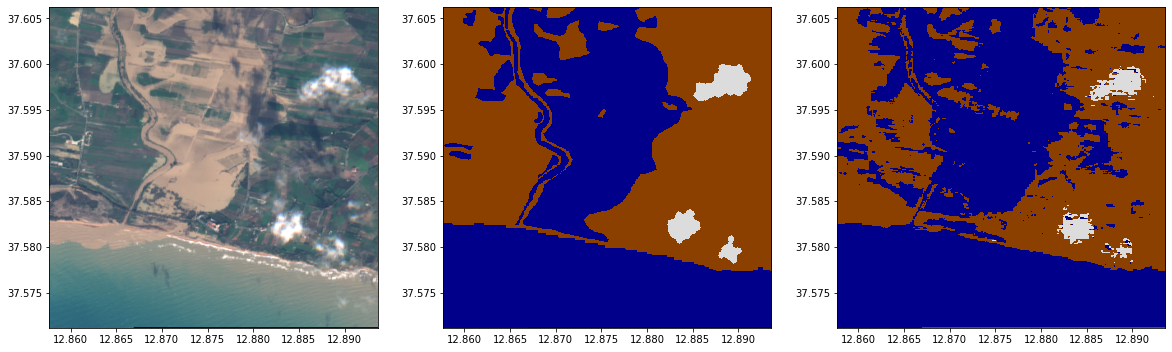

In [8]:
plot_inference_set(torch_inputs, torch_targets, prediction, transform)

## Calculate performance metric for inference pair

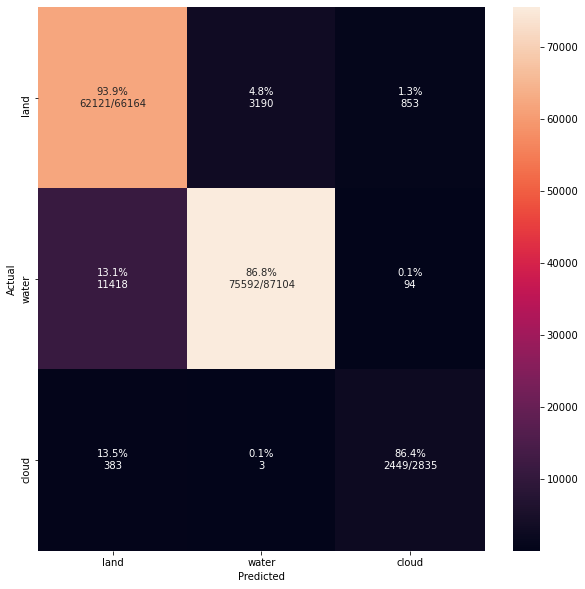

In [9]:
confusion_mat = metrics.compute_confusions(torch_targets, prediction, opt.num_class, remove_class_zero=True) # (batch_size, num_class, num_class)
confusion_mat = confusion_mat.sum(dim=0) # add by the batch dimension
metrics.cm_analysis(np.array(confusion_mat), labels=["land","water","cloud"])